## 환경세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 5.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [23]:
train = pd.read_csv('/content/drive/MyDrive/khu_dacon/open/new_train.csv')
test = pd.read_csv('/content/drive/MyDrive/khu_dacon/open/new_test.csv')

## 데이터 처리

기타 실험
- occyp_type : DAYS_EMPLOYED == 0 이면서 occype_type이 NaN일 시 no_work로 처리
- occyp_type별 income_total을 구해 비슷한 소득을 가진 직업군끼리 같은 범주로 묶어 실험 진행

In [24]:
# 결측치 처리
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

# 이상치 처리
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)
# child_num <= 7

# 의미없는 변수 제거
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

# unemployed 데이터는 무직자로 판단, 0처리
train['YEARS_EMPLOYED'] = train['YEARS_EMPLOYED'].map(lambda x: 0 if x == 'unemployed' else x)
test['YEARS_EMPLOYED'] = test['YEARS_EMPLOYED'].map(lambda x: 0 if x == 'unemployed' else x)
train = train.astype({'YEARS_EMPLOYED':'float'})
test = test.astype({'YEARS_EMPLOYED':'float'})

train['ADD_DAYS_EMPLOYED'] = train['ADD_DAYS_EMPLOYED'].map(lambda x: 0 if x == 'unemployed' else x)
test['ADD_DAYS_EMPLOYED'] = test['ADD_DAYS_EMPLOYED'].map(lambda x: 0 if x == 'unemployed' else x)
train = train.astype({'ADD_DAYS_EMPLOYED':'float'})
test = test.astype({'ADD_DAYS_EMPLOYED':'float'})

# 음수->양수 변환
feats = ['YEARS_BIRTH', 'begin_month', 'YEARS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    print(feat)
    test[feat]=np.abs(test[feat])

YEARS_BIRTH
begin_month
YEARS_EMPLOYED


## 변수 생성
- **‘before_EMPLOYED’** : YEARS_BIRTH, ADD_DAYS_BRITH, YEARS_EMPLOYED, ADD_DAYS_EMPLOYED를 사용하여 사람이 직업을 갖기 전까지의 일수를 기록하는 feature를 생성하였습니다.
- **‘income_total_beforeEMP_ratio’** : 사람의 총 수입을 나타내는 feature인 ‘income_total’을 위에서 새로 생성한 ‘before_EMPLOYED’로 나누어 이것에 대한 비율을 새로운 feature로 생성하였습니다.
- **‘before_EMPLOYED_m’, ‘before_EMPLOYED_w’** : 고용되기 전까지의 일수를 월 단위와 주 단위로 하여 해당하는 값들을 새로운 feature로 만들었습니다.
- 기존의 ‘YEARS_BRITH’를 **AGE**라는 feature로 이름을 변경하였으며, **‘DAYS_BRITH’**는 사람이 태어난 일수를 value로 가지는 feature 입니다. 또한, 이를 주 단위로 기록한 **‘DAYS_BRITH_m’**이라는 feature도 생성하였습니다.
- 신용카드를 사용한 기간을 월 단위로 기록한 ‘begin_month’ feature를 사용하여 이를 연 단위로 변환한 **‘used_years’**를 생성하였습니다.
- **‘DAYS_EMPLOYED’** : ‘YEARS_EMPLOYED’, ‘ADD_DAYS_EMPLOYED’ feature를 사용하여 고용된 일 수를 기록한 feature 입니다. ‘EMPLOYED’는 이를 연 단위로 변환한 feature 입니다. ‘
- ‘**EMPLOYED**’ : ‘DAYS_EMPLOYED’ feature를 연단위로 기록한 feature 입니다. 
’**DAYS_EMPLOYED_m**’ : 연단위를 제거한 고용된 개월수를 의미합니다.
- ‘**ability**’ : 총 소득을 의미하는 ‘income_total’과 지금까지 살아온 일수와 근무일수를 더한 값을 나눈 값을 feature로 생성하였습니다.
- ‘**income_mean**’  : 그 사람의 총 소득(’income_total’)을 그 사람이 부양하는 가족의 수로 나눈 feature 입니다.
- **ID :** 
child_num, income_total_, DAYS_BIRTH, DAYS_EMPLOYED, email, family_size, gender, car, reality, income_type, edu_type, family_type, house_type, occyp_type을 string의 형식으로 전부 더한 값을 해당 sample의 고유성을 나타내는 feature로 생성하였습니다.


기타 실험 변수
- 발급빠르기 : begin_month / DAYS BIRTH (현실에서 신용카드를 일찍 발급해서 사용할수록, 신용등급이 높게 나오는 경향성이 있다.)
- 벌이/나이 : income_total / age (나이베 비해 일찍 돈을 벌었거나 많이 버는 것에 대해, 어느정도 신용 등급에 영향이 있을 것이라고 판단함)
- 부담지수 : income_total / (age-35)**3 * (family_size) (적정 나이가 지나고 비혼이든, 혼인 사애든 부양할 가족이 있을 것이라 생각을 하였습니다. 보통 가정에서 생계를 온전히 부담하는 나이는 여러 조사 결과 35세 정도로 측정하여 가족 부담지수를 생성하였습니다.)
- card_num : 성, 나이, 총 소득, 소득 타입, 취직일수가 같을 때 같은 사람이라고 판단하였습니다. 현실에서도 신용이 좋은 사람은 여러 경우에서 다른 혜택을 받기 위해 카드를 여러개 발급하는 경우가 있기 때문에 생성하여 실험

In [25]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = (df['YEARS_BIRTH']*365 + df['ADD_DAYS_BIRTH']) - (df['YEARS_EMPLOYED']*365 + df['ADD_DAYS_EMPLOYED'])
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['YEARS_BIRTH']
    df['DAYS_BIRTH'] = df['YEARS_BIRTH']*365 + df['ADD_DAYS_BIRTH'] # -> 어떤 차이?
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차)) 
    df['DAYS_EMPLOYED'] = df['YEARS_EMPLOYED']*365 + df['ADD_DAYS_EMPLOYED'] 
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365 # -> 핵심
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

## 변수 제거
- 다중공선성이란? : 변수들간의 상관관계가 있는지 여부를 판단하는 지표. 회귀분석 돌릴 때 변수들끼리 독립이라는 가정을 해야 하는데, 상관관계가 심하게 높으면 독립성 위배 + target변수를 추측할 때, target변수의 설명력이 떨어진다.
- VIF가 10이 넘어가는 변수들을 제거해보기도, inf인것만 제거해보기도 하였으나 BRITH, EMPLOYED관련 변수들과 child_num변수를 제거했을 때 가장 성능이 좋았다.

In [26]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  24
Number of Categorical features:  9


In [27]:
# VIF기능을 제공하는 라이브러리 불러오기
from statsmodels.stats.outliers_influence import variance_inflation_factor

temp = train[numerical_feats]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(temp.values, i) for i in range(temp.shape[1])]
vif["features"] = numerical_feats
vif

,VIF Factor,features
0,39.830206,income_total
1,7.255775,child_num
2,1.544201,phone_case
3,1.118275,email
4,51.997932,family_size
5,3.531490,begin_month
6,inf,YEARS_BIRTH
7,inf,ADD_DAYS_BIRTH
8,inf,YEARS_EMPLOYED
9,inf,ADD_DAYS_EMPLOYED


In [28]:
# 다중공선성을 띄는 변수 제거
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'YEARS_BIRTH', 'ADD_DAYS_BIRTH', 'YEARS_EMPLOYED', 'ADD_DAYS_EMPLOYED']
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [29]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  17
Number of Categorical features:  9


## log변환(치우친 분포 정상화)
- 그래프를 그려봤을 때, 정규분포 형태가 아니라 치우처져 있는 것을 볼 수 있다.
- 왜도와 첨도를 줄여 정규성을 높여, 분석 시 정확한 값을 얻도록 한다.

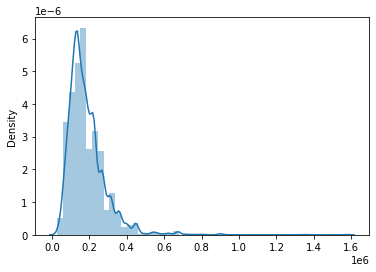

In [40]:
sns.distplot(train[['income_total']])

In [41]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

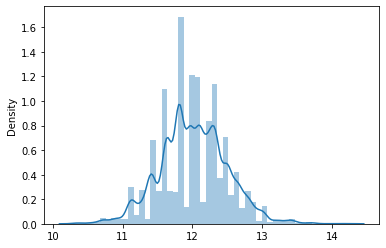

In [42]:
sns.distplot(train[['income_total']])

In [43]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

## 군집화(중복 데이터 처리)
- 데이터를 살펴보면 한 사용자가 여러 카드를 사용해 연체를 한 여부가 나온다.
- 중복 사용자를 처리해주기 위해 군집화를 사용하는데, 이 군집화 개수의 영향도 미미하지 않을 것으로 생각했다.

- k-means clustering기법의 k값을 정하는 방법은 대표적으로 Elbow Method, Silhouette Score가 있다.
- 두 방법을 사용한 결과, 5-6부터 비슷한 값을 가지고 35-40 구간에서 최적의 score를 보이는 결과를 얻었다.

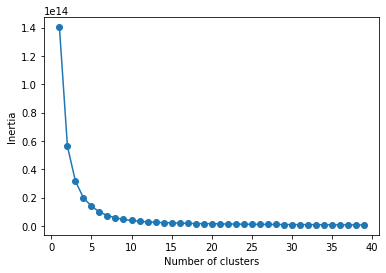

In [44]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

inertia = []

X = train.drop(['credit'], axis=1)
for i in range(1, 40):
    kmeans_plus = KMeans(n_clusters=i, init='k-means++')
    kmeans_plus.fit(X)
    inertia.append(kmeans_plus.inertia_)

plt.plot(range(1, 40), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [45]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=40, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

## scaling의 변화
- 대표적인 스케일러는 총 4개가 있다.
- Standard : 평균과 표준편차를 사용
- MinMax : 최대/최소값이 각각 1,0이 되도록 스케일링
- MaxAbs : 최대절대값와 0이 각각 1,0이 되도록 스케일링
- Robust : 중앙값과 IQR을 사용하여, 아웃라이어 영향 최소화

- 데이터에 이상치가 섞여 있다고 판단하여 Robust를 적용시켜보았으나 Standard scaler가 가장 성능이 좋았다.

In [ ]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

# Feature Selection
- model을 학습시키기 위한 최적의 feature set 조합을 찾는 것이 필수라고 생각
- 모든 feature set조합에 대해 실험 진행. 파라미터를 변경하며 찾아보려 했으나, 오히려 성능이 많이 떨어지는 현상이 발생하여 선정하지 않음.

In [ ]:
'''
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
feature_names = ['F{}'.format(i) for i in range(train_X.shape[1])]
train_pool = Pool(train_X, train_y, feature_names=feature_names)
test_pool = Pool(test_X, test_y, feature_names=feature_names)

model =  CatBoostClassifier(learning_rate=0.22999586428143728, bagging_temperature=0.022592797420156956, n_estimators=2764, 
                                 max_depth=4, random_strength=32, colsample_bylevel=0.6332063738136893, l2_leaf_reg=8.147757462899138e-06, 
                                 min_child_samples=84, max_bin=307, od_type='Iter')

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-21',
    num_features_to_select=15,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)
''

## Optuna - 하이퍼 파라미터 최적화
- Optuna란? : ML알고리즘의 하이퍼파라미터 튜닝을 자동화해주는 오픈소스 툴
- 해당 오픈소스를 통해 model의 최적의 파라미터를 찾아내는 방법을 사용했다.
- 많은 시간을 할애하므로, 성능 비교를 할 때는 하이퍼 파라미터를 고정시키고 진행

In [ ]:
#Optuna용 Train셋
X = train.drop(['credit'],axis=1)
y = train['credit']
X_test = test.copy()

In [ ]:
def objective(trial):
  param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)
  
  cat_features = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
  cat = CatBoostClassifier(**param)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_pred = cat.predict_proba(X_valid)
  log_score = log_loss(y_valid, cat_pred)

  return log_score

In [ ]:
!pip install optuna

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
import random

import optuna
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

## Modeling(Catboost)

model 실험
- Tabnet(딥러닝)
- XGBoost + Catboost + LightGBM 스태킹
- Catboost 단일 모델
- 위 model들 중 catboost가 가장 높게 나와 선정하였다.

Catboost model의 특성
- Level-wise로 트리를 만들어나가는 방식이다. (BFS 알고리즘처럼 트리를 만들어나가는 형태)
- Orderd Boosting : 일괄적으로 모든 훈련 데이터를 대상으로 잔차를 계산하는 기존 부스팅 모델과는 다르게, 일부 데이터만 가지고 잔차를 계산한 뒤 모델을 형성한 후 그 뒤 데이터의 잔차는 앞서 만든 모델로 예측한 값을 사용한다.
- Random Permutation : 데이터를 셔플링하여 뽑아내기 때문에 오버피팅 방지, 트리를 다각적으로 만들어준다.
- Ordered Target Encoding : 범주형변수를 수치형 변수로 인코딩 시키는 방법으로, 이전 데이터의 타겟 값만을 사용해 Data Leakage를 방지해준다. 
- Categorical Feauture Combinations : information gain이 동일한 두 feature를 하나의 feature로 묶어, feature selection 부담이 조금 줄어든다.

Catboost의 한계
- sparse matrix는 처리하지 못한다.
- 데이터 대부분이 수치형일 때 학습 속도가 느리다.

In [48]:
n_est = 2000
seed = 42
n_fold = 19
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [49]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=2000)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], 3))
cat_pred_test = np.zeros((X_test.shape[0], 3))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  #model_cat = CatBoostClassifier(**study.best_params) # optuna로부터 나온 최적의 파라미터
  model_cat = CatBoostClassifier(learning_rate=0.22999586428143728, bagging_temperature=0.022592797420156956, n_estimators=2764, 
                                 max_depth=4, random_strength=32, colsample_bylevel=0.6332063738136893, l2_leaf_reg=8.147757462899138e-06, 
                                 min_child_samples=84, max_bin=307, od_type='Iter')
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
# 15 0.8047
# 14 0.8047
# 13 0.8045
# 16 0.8040
# 17 0.8035
# 18 0.8030
# 19 0.8019
# 20 0.8027
# 21 0.8026


----------------- Fold 0 -----------------

0:	learn: 1.0841705	test: 1.0841640	best: 1.0841640 (0)	total: 64.2ms	remaining: 2m 57s
100:	learn: 0.8476640	test: 0.8238248	best: 0.8230234 (88)	total: 3.27s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8230234141
bestIteration = 88

Shrink model to first 89 iterations.
CV Log Loss Score: 0.823023

----------------- Fold 1 -----------------

0:	learn: 1.0841705	test: 1.0841640	best: 1.0841640 (0)	total: 9.96ms	remaining: 27.5s
100:	learn: 0.8514807	test: 0.7690132	best: 0.7690132 (100)	total: 2.4s	remaining: 1m 3s
200:	learn: 0.8292216	test: 0.7676242	best: 0.7667526 (192)	total: 6.01s	remaining: 1m 16s
300:	learn: 0.8101564	test: 0.7659453	best: 0.7649962 (255)	total: 8.94s	remaining: 1m 13s
400:	learn: 0.7925357	test: 0.7649797	best: 0.7642835 (390)	total: 12.3s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7642835401
bestIteration = 390

Shrink model to f

Feature Importance 시각화

In [50]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

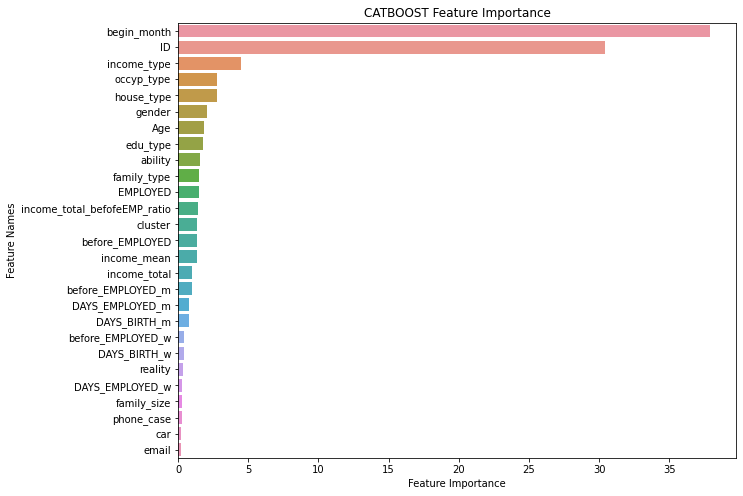

In [51]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

submission 파일 제출

In [52]:
sample_submission = pd.read_csv("/content/drive/MyDrive/khu_dacon/open/sample_submission.csv")

In [53]:
sample_submission.iloc[:, 1:] = cat_pred_test
sample_submission

,index,0,1,2
0,26457,0.848574,0.054664,0.096762
1,26458,0.872347,0.125665,0.001988
2,26459,0.633491,0.174171,0.192338
3,26460,0.135840,0.566791,0.297369
4,26461,0.272206,0.289565,0.438229
...,...,...,...,...
9995,36452,0.141384,0.821361,0.037255
9996,36453,0.100033,0.288527,0.611440
9997,36454,0.544319,0.431082,0.024599
9998,36455,0.528523,0.178886,0.292591


In [ ]:
sample_submission.to_csv("/content/drive/MyDrive/khu_dacon/open/cat_0518_optuna_19.csv", index=False)